In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter

import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple, name_data
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle
from filters import filter_butter
from fast_open_data import open_data_filter

In [2]:
def sep_modo(data, estimated_data, modo_sequence, classes):
    
    
    V_seq = np.zeros(len(modo_sequence))
    Var_seq = np.zeros(len(modo_sequence))
    V_modo = np.zeros(len(classes))
    Var_modo = np.zeros(len(classes))
    
    modo = np.zeros((data.shape))

    for i in range(len(modo_sequence)):
        if i == 0:
            modo[:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[:estimated_data[i]]))
            
            
        elif i == (len(estimated_data)):
            modo[estimated_data[i-1]:] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:]))
        
        else:
            modo[estimated_data[i-1]:estimated_data[i]] = modo_sequence[i]
            V_seq[i] = np.mean(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
            Var_seq[i] = np.var(np.diff(data[estimated_data[i-1]:estimated_data[i]]))
                    
    for n in range(len(classes)):
        idx = np.where(np.array(modo_sequence) == n+1)[0]
        V_modo[n] = np.mean(np.array(V_seq)[idx])
        Var_modo[n] = np.mean(np.array(Var_seq)[idx])
        
    return modo, V_seq, V_modo, Var_seq, Var_modo

In [3]:
def transition_matrix(modo, classes):
    
    transitions = np.zeros(modo.shape)
    not_transitions = np.zeros(modo.shape)
    transition_matrix = np.zeros([len(classes), len(classes)])
    

    for i in range(len(classes)):
        for j in range(len(classes)):
            for n in range(len(modo)-1):
                t = n + 1
                
                if (modo[t-1] == i+1 and modo[t] == j+1):
                    transitions[t] = 1

                else:
                    transitions[t] = 0

                if modo[t] == i+1:
                    not_transitions[t] = 1

                else:
                    not_transitions[t] = 0
            
            transition_matrix[i, j] = np.sum(transitions)/np.sum(not_transitions)
            #plt.plot(transitions, label = 'Transitions: '+str(i)+','+str(j))
            #plt.legend()
            #plt.show()
            #plt.plot(not_transitions, label = 'Not Transitions: '+str(i)+','+str(j))
            #plt.legend()
            #plt.show()
            
    return transition_matrix

In [4]:
S, R, L = open_data_filter(52, key = 'S1_Synched')
S1, R1, L1 = open_data_filter(23, key = 'S1_Synched')

# Escolher o movimento completo ou escolher o movimento separado

* Movimento completo = sentar e levantar
* Movimento separado = movimento de sentar separado do movimento de levantar

In [5]:
freq_amostragem = 120
# dados para voluntário 52
estimated_R = [ 30, 330, 585, 740]
estimated_L = [ 100, 330, 595, 790]
estimated_S = [ 140, 264, 365, 570, 647, 725]

sequence_R_L = [1,2,1,3,1]
sequence_S = [1,2,3,1,2,3,1]

sequence = sequence_S.copy()
sequence.extend(sequence_R_L) 
classes = np.unique(sequence)



estimated_complete = [ 100, 140, 264, 330, 365, 570, 595, 647, 725, 790]
sequence_complete =  [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1]

sep = 470 
estimated_sit_SL = [ 100, 140, 264, 330, 365]
sequence_sit_SL =  [ 1, 2, 3, 4, 5, 6]
S_sit = S[:sep]
L_sit = L[:sep]
R_sit = R[:sep]

estimated_rise_SL = [ 570-sep, 595-sep, 647-sep, 725-sep, 790-sep]
sequence_rise_SL =  [ 1, 2, 3, 4, 5, 6]
S_rise = S[sep:]
L_rise = L[sep:]
R_rise = R[sep:]

In [6]:
sequence_total = sequence_complete.copy()
classes_complete = np.unique(sequence_complete)

sequence_sit = sequence_sit_SL.copy()
classes_sit = np.unique(sequence_sit_SL)

sequence_rise = sequence_rise_SL.copy()
classes_rise = np.unique(sequence_rise_SL)

In [7]:
modo_S, V_seq_S, V_modo_S, Var_seq_S, Var_modo_S = sep_modo(S, estimated_S, sequence_S, classes)
modo_L, V_seq_L, V_modo_L, Var_seq_L, Var_modo_L = sep_modo(L, estimated_L, sequence_R_L, classes)
modo_R, V_seq_R, V_modo_R, Var_seq_R, Var_modo_R = sep_modo(R, estimated_R, sequence_R_L, classes)


modo_complete, V_seq_cS, V_modo_cS, Var_seq_cS, Var_modo_cS = sep_modo(S, estimated_complete, sequence_complete, classes_complete)
modo_complete, V_seq_cL, V_modo_cL, Var_seq_cL, Var_modo_cL = sep_modo(L, estimated_complete, sequence_complete, classes_complete)

modo_sit_S, V_seq_sit_S, V_modo_sit_S, Var_seq_sit_S, Var_modo_sit_S = sep_modo(S_sit, estimated_sit_SL, sequence_sit, classes_sit)
modo_sit_L, V_seq_sit_L, V_modo_sit_L, Var_seq_sit_L, Var_modo_sit_L = sep_modo(L_sit, estimated_sit_SL, sequence_sit, classes_sit)

modo_rise_S, V_seq_rise_S, V_modo_rise_S, Var_seq_rise_S, Var_modo_rise_S= sep_modo(S_rise, estimated_rise_SL, sequence_rise, classes_rise)
modo_rise_L, V_seq_rise_L, V_modo_rise_L, Var_seq_rise_L, Var_modo_rise_L = sep_modo(L_rise, estimated_rise_SL, sequence_rise, classes_rise)

# IMM aplicado ao movimento completo de sentar e levantar

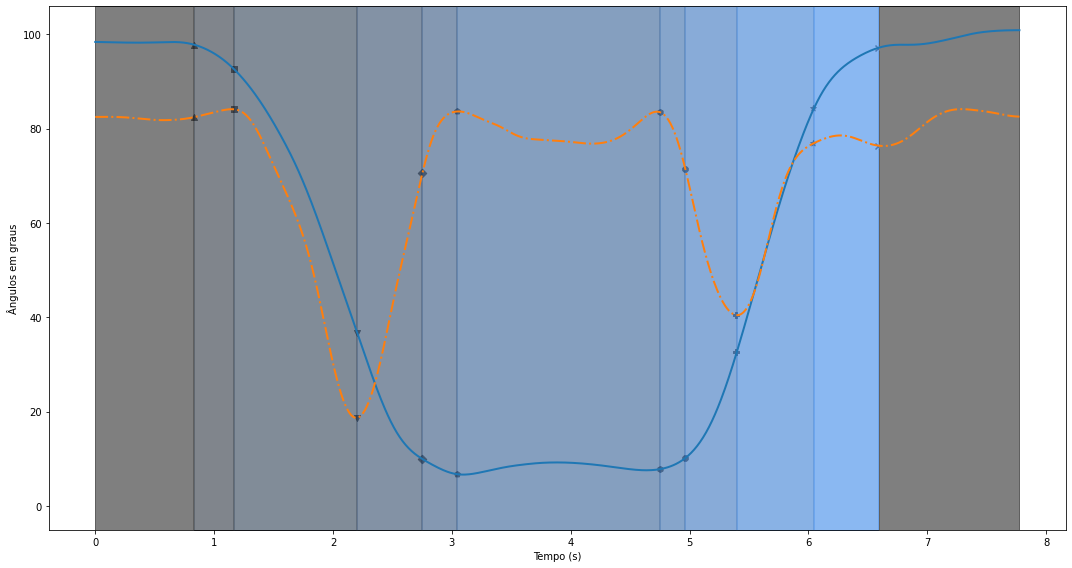

In [8]:
t = np.linspace(0, len(S) / 120, len(S))
t1 = np.linspace(0, len(S1) / 120, len(S1))

markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_spine = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
cores = [(0.1, 0.05, 0.1, 0.1), 'k', 'y', 'r', 'c', 'm', 'w', 'b', 'g', 'peru', 'cyan']

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=[15,8])
ax1.plot(t, L, label='Perna esquerda filtrada em 0,7 Hz', 
         linewidth=2)
ax1.plot(t, S, label='Tronco filtrado em 1,3 Hz', 
         linestyle='-.', linewidth=2)

for i in range(len(estimated_complete)):    
    ax1.scatter(estimated_complete[i]/(np.array(freq_amostragem)), L[estimated_complete[i]], 
            marker=markers[i], color='gray')
    ax1.scatter(estimated_complete[i]/(np.array(freq_amostragem)), S[estimated_complete[i]], 
            marker=markers[i], color='gray')
    
    threshold = sequence_complete[i]
    ax1.fill_between(t, 0, 1, where=modo_complete == threshold,
                color=(0.01*i, 0.05*i, 0.1*i, 0.5), alpha=0.5, transform=ax1.get_xaxis_transform())
    

#plt.title('Fases do DTW para sentar e levantar')
#plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Tempo (s)')
plt.grid(False)
plt.axis(True)
#plt.grid()
fig.tight_layout()
#plt.savefig(f_name + 'Fases do DTW para tronco e perna esquerda.png')
plt.show()

In [9]:
from filterpy.kalman import KalmanFilter, IMMEstimator
from filterpy.common import Q_discrete_white_noise, kinematic_kf
import time

In [10]:
transitions_complete = transition_matrix(modo_complete, classes_complete)

In [11]:
# iniciando os 10 filtros, 1 para cada modo
kf1 = kinematic_kf(2, 1)
kf2 = kinematic_kf(2, 1)
kf3 = kinematic_kf(2, 1)
kf4 = kinematic_kf(2, 1)
kf5 = kinematic_kf(2, 1)
kf6 = kinematic_kf(2, 1)
kf7 = kinematic_kf(2, 1)
kf8 = kinematic_kf(2, 1)
kf9 = kinematic_kf(2, 1)
kf10 = kinematic_kf(2, 1)

dt = 1
r = 5   #.R = 5
p = 1000.  #.P = 1000.

kf1.x = np.array([S[0], L[0], V_modo_cS[0], V_modo_cL[0]])       # initial state (location and velocity)
kf1.P *= p                 # covariance matrix
kf1.R *= r                     # state uncertainty
kf1.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[0]) # process uncertainty


kf2.x = np.array([S[estimated_complete[0]], L[estimated_complete[0]], 
                  V_modo_cS[classes_complete[0]], V_modo_cL[classes_complete[0]]])   # initial state (location and velocity)
kf2.P *= p                 # covariance matrix
kf2.R *= r                     # state uncertainty
kf2.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[1]) # process uncertainty


kf3.x = np.array([S[estimated_complete[1]], L[estimated_complete[1]], 
                  V_modo_cS[classes_complete[1]], V_modo_cL[classes_complete[1]]])   # initial state (location and velocity)
kf3.P *= p                 # covariance matrix
kf3.R *= r                     # state uncertainty
kf3.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[2]) # process uncertainty

kf4.x = np.array([S[estimated_complete[2]], L[estimated_complete[2]], 
                  V_modo_cS[classes_complete[2]], V_modo_cL[classes_complete[2]]])   # initial state (location and velocity)
kf4.P *= p                 # covariance matrix
kf4.R *= r                     # state uncertainty
kf4.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[3]) # process uncertainty


kf5.x = np.array([S[estimated_complete[3]], L[estimated_complete[3]], 
                  V_modo_cS[classes_complete[3]], V_modo_cL[classes_complete[3]]])   # initial state (location and velocity)
kf5.P *= p                 # covariance matrix
kf5.R *= r                     # state uncertainty
kf5.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[4]) # process uncertainty


kf6.x = np.array([S[estimated_complete[4]], L[estimated_complete[4]], 
                  V_modo_cS[classes_complete[4]], V_modo_cL[classes_complete[4]]])   # initial state (location and velocity)
kf6.P *= p                 # covariance matrix
kf6.R *= r                     # state uncertainty
kf6.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[5]) # process uncertainty


kf7.x = np.array([S[estimated_complete[5]], L[estimated_complete[5]], 
                  V_modo_cS[classes_complete[5]], V_modo_cL[classes_complete[5]]])   # initial state (location and velocity)
kf7.P *= p                 # covariance matrix
kf7.R *= r                     # state uncertainty
kf7.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[6]) # process uncertainty


kf8.x = np.array([S[estimated_complete[6]], L[estimated_complete[6]], 
                  V_modo_cS[classes_complete[6]], V_modo_cL[classes_complete[6]]])   # initial state (location and velocity)
kf8.P *= p                 # covariance matrix
kf8.R *= r                     # state uncertainty
kf8.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[7]) # process uncertainty


kf9.x = np.array([S[estimated_complete[7]], L[estimated_complete[7]], 
                  V_modo_cS[classes_complete[7]], V_modo_cL[classes_complete[7]]])   # initial state (location and velocity)
kf9.P *= p                 # covariance matrix
kf9.R *= r                     # state uncertainty
kf9.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[8]) # process uncertainty


kf10.x = np.array([S[estimated_complete[8]], L[estimated_complete[8]], 
                  V_modo_cS[classes_complete[8]], V_modo_cL[classes_complete[8]]])   # initial state (location and velocity)
kf10.P *= p                 # covariance matrix
kf10.R *= r                     # state uncertainty
kf10.Q = Q_discrete_white_noise(4, dt, Var_modo_cS[9]) # process uncertainty

filters = [kf1, kf2, kf3, kf4, kf5, kf6, kf7, kf8, kf9, kf10]
mu = [0.82, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]  # each filter is equally likely at the start
M = np.array(transitions_complete)
imm = IMMEstimator(filters, mu, M)

In [12]:
results = []
prob_estado = []
transitions = []
z = np.c_[S, L]

for i, z in enumerate(z):
    
    # perform predict/update cycle
    imm.predict()
    imm.update(z)
    #print((imm.x.T).shape)
    results.append(imm.x.copy())
    prob_estado.append(imm.mu.copy())
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)


estado_previsto = np.zeros(S.shape)
for i in range(len(S)):
    estado_previsto[i] = np.where(prob_estado[i] == max(prob_estado[i]))[0][0]

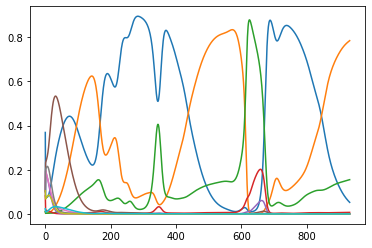

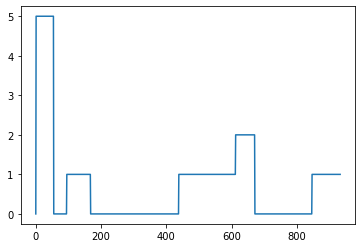

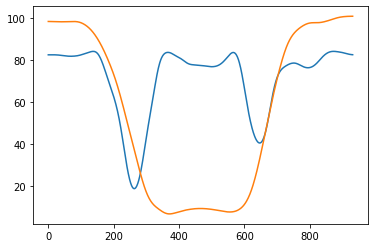

In [14]:
plt.plot(prob_estado)
plt.show()
plt.plot(estado_previsto)
plt.show()
plt.plot(S)
plt.plot(L)
plt.show()

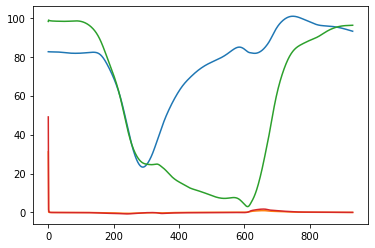

In [15]:
plt.plot(results)

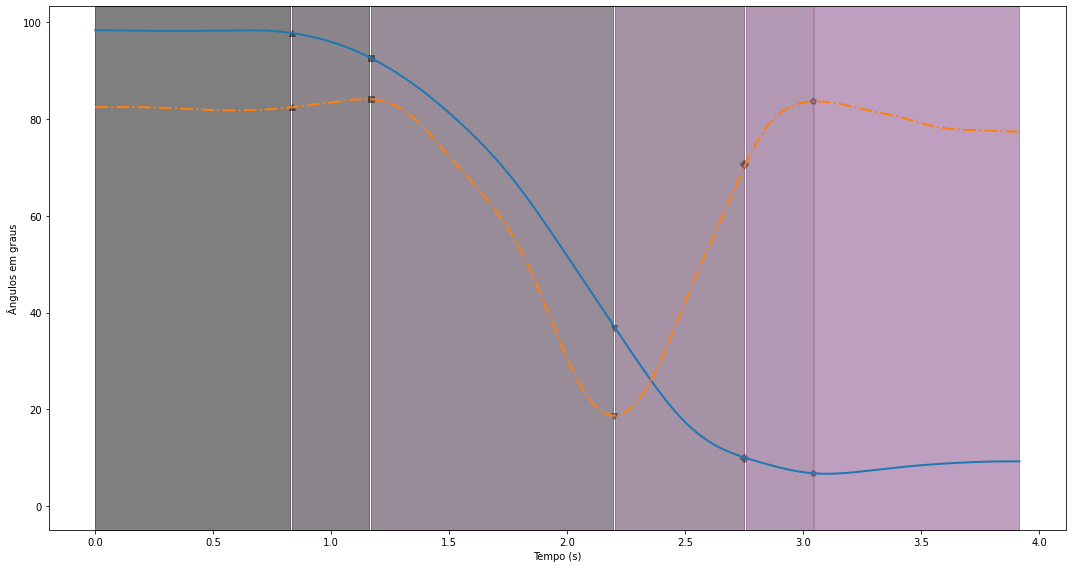

In [16]:
t_sit = np.linspace(0, len(S_sit) / 120, len(S_sit))
#t1_sit = np.linspace(0, len(S1[:500]) / 120, len(S1[:500]))

markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_spine = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
cores = ['k', 'y', 'r', 'c', 'm', 'w', 'b', 'g', 'peru', 'cyan']

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=[15,8])
ax1.plot(t_sit, L_sit, label='Perna esquerda filtrada em 0,7 Hz', 
         linewidth=2)
ax1.plot(t_sit, S_sit, label='Tronco filtrado em 1,3 Hz', 
         linestyle='-.', linewidth=2)

for i in range(len(estimated_sit_SL)):    
    ax1.scatter(estimated_sit_SL[i]/(np.array(freq_amostragem)), L[estimated_sit_SL[i]], 
            marker=markers[i], color='gray')
    ax1.scatter(estimated_sit_SL[i]/(np.array(freq_amostragem)), S[estimated_sit_SL[i]], 
            marker=markers[i], color='gray')
    
    threshold = sequence_sit[i]
    ax1.fill_between(t_sit, 0, 1, where=modo_sit_S == threshold,
                color=(0.1*i, 0.05*i, i*0.1, 0.5), alpha=0.5, transform=ax1.get_xaxis_transform())
    if i == len(estimated_sit_SL)-1:
        i+=1
        threshold +=1
        ax1.fill_between(t_sit, 0, 1, where=modo_sit_S == threshold,
                color=(0.1*i, 0.05*i, i*0.1, 0.5), alpha=0.5, transform=ax1.get_xaxis_transform())

#plt.title('Fases do DTW para sentar e levantar')
#plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Tempo (s)')
plt.grid(False)
plt.axis(True)
#plt.grid()
fig.tight_layout()
#plt.savefig(f_name + 'Fases do DTW para tronco e perna esquerda.png')
plt.show()

In [17]:
transitions_sit = transition_matrix(modo_sit_S, classes_sit)

In [18]:
dt = 1/120
r = 10   #.R = 5
p = 10000000.  #.P = 1000.

# iniciando os 6 filtros, 1 para cada modo
kf1 = kinematic_kf(2, 1, dt)
kf2 = kinematic_kf(2, 1, dt)
kf3 = kinematic_kf(2, 1, dt)
kf4 = kinematic_kf(2, 1, dt)
kf5 = kinematic_kf(2, 1, dt)
kf6 = kinematic_kf(2, 1, dt)


kf1.x = np.array([S_sit[0], L_sit[0], V_modo_sit_S[0], V_modo_sit_L[0]])       # initial state (location and velocity)
kf1.P *= p                 # covariance matrix
kf1.R *= r                     # state uncertainty
kf1.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[0], block_size=2) # process uncertainty


kf2.x = np.array([S_sit[estimated_sit_SL[0]], L_sit[estimated_sit_SL[0]], 
                  V_modo_sit_S[classes_sit[0]], V_modo_sit_L[classes_sit[0]]])   # initial state (location and velocity)
kf2.P *= p                 # covariance matrix
kf2.R *= r                     # state uncertainty
kf2.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[1], block_size=2) # process uncertainty


kf3.x = np.array([S_sit[estimated_sit_SL[1]], L_sit[estimated_sit_SL[1]], 
                  V_modo_sit_S[classes_sit[1]], V_modo_sit_L[classes_sit[1]]])   # initial state (location and velocity)
kf3.P *= p                 # covariance matrix
kf3.R *= r                     # state uncertainty
kf3.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[2], block_size=2) # process uncertainty

kf4.x = np.array([S_sit[estimated_sit_SL[2]], L_sit[estimated_sit_SL[2]], 
                  V_modo_sit_S[classes_sit[2]], V_modo_sit_L[classes_sit[2]]])   # initial state (location and velocity)
kf4.P *= p                 # covariance matrix
kf4.R *= r                     # state uncertainty
kf4.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[3], block_size=2) # process uncertainty


kf5.x = np.array([S_sit[estimated_sit_SL[3]], L_sit[estimated_sit_SL[3]], 
                  V_modo_sit_S[classes_sit[3]], V_modo_sit_L[classes_sit[3]]])   # initial state (location and velocity)
kf5.P *= p                 # covariance matrix
kf5.R *= r                     # state uncertainty
kf5.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[4], block_size=2) # process uncertainty


kf6.x = np.array([S_sit[estimated_sit_SL[4]], L_sit[estimated_sit_SL[4]], 
                  V_modo_sit_S[classes_sit[4]], V_modo_sit_L[classes_sit[4]]])   # initial state (location and velocity)
kf6.P *= p                 # covariance matrix
kf6.R *= r                     # state uncertainty
kf6.Q = Q_discrete_white_noise(2, dt, Var_modo_sit_S[5], block_size=2) # process uncertainty


filters = [kf1, kf2, kf3, kf4, kf5, kf6]
mu = [0.9, 0.02, 0.02, 0.02, 0.02, 0.02]  # each filter is equally likely at the start
M = np.array(transitions_sit)
imm = IMMEstimator(filters, mu, M)

In [19]:
results = []
prob_estado = []
transitions = []
z = np.c_[S_sit, L_sit]

for i, z in enumerate(z):
    
    # perform predict/update cycle
    imm.predict()
    imm.update(z)
    #print((imm.x.T).shape)
    results.append(imm.x.copy())
    prob_estado.append(imm.mu.copy())
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)


estado_previsto = np.zeros(S_sit.shape)
for i in range(len(S_sit)):
    estado_previsto[i] = np.where(prob_estado[i] == max(prob_estado[i]))[0][0]

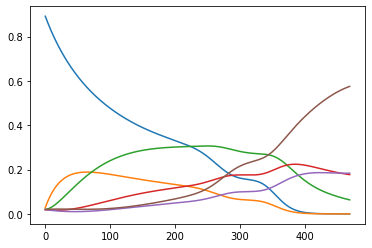

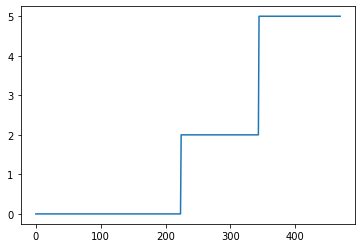

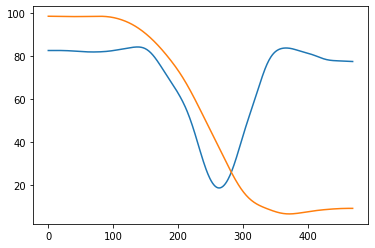

In [20]:
plt.plot(prob_estado)
plt.show()
plt.plot(estado_previsto)
plt.show()
plt.plot(S_sit)
plt.plot(L_sit)
plt.show()

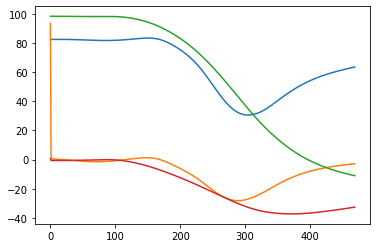

In [21]:
plt.plot(results)

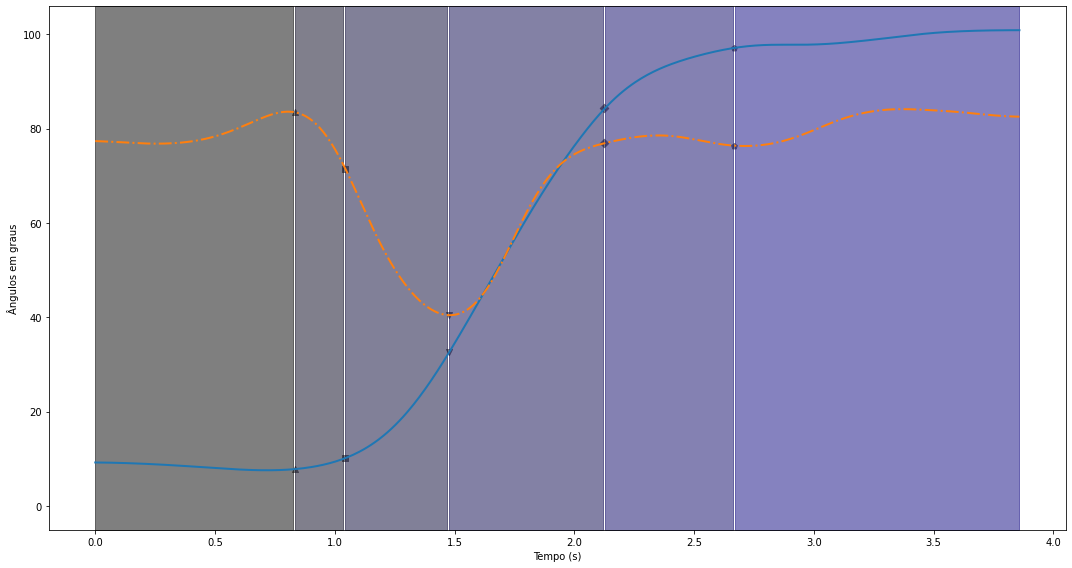

In [22]:
t_rise = np.linspace(0, len(S_rise) / 120, len(S_rise))
#t1_sit = np.linspace(0, len(S1[:500]) / 120, len(S1[:500]))

markers=['^', 's', 'v', 'D', 'p', 'h', '8', 'P', '*', 'x']

rowing_phases_leg = ['Dobrar Perna Sentar', 'Perna Dobrada', 'Esticar Perna Levantar', 'Perna Esticada']
rowing_phases_spine = ['Inclinar Tronco Sentar', 'Inclinação Máxima do Tronco', 'Sentado Estabilizado', 
                        'Inclinar Tronco Levantar', 'Inclinação Máxima Levantar', 'Em Pé Estabilizado ']
cores = ['k', 'y', 'r', 'c', 'm', 'w', 'b', 'g', 'peru', 'cyan']

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=[15,8])
ax1.plot(t_rise, L_rise, label='Perna esquerda filtrada em 0,7 Hz', 
         linewidth=2)
ax1.plot(t_rise, S_rise, label='Tronco filtrado em 1,3 Hz', 
         linestyle='-.', linewidth=2)

for i in range(len(estimated_rise_SL)):    
    ax1.scatter(estimated_rise_SL[i]/(np.array(freq_amostragem)), L_rise[estimated_rise_SL[i]], 
            marker=markers[i], color='gray')
    ax1.scatter(estimated_rise_SL[i]/(np.array(freq_amostragem)), S_rise[estimated_rise_SL[i]], 
            marker=markers[i], color='gray')
    
    threshold = sequence_rise[i]
    ax1.fill_between(t_rise, 0, 1, where=modo_rise_S == threshold,
                color=(0.01*i, 0.005*i, i*0.1, 0.1*i), alpha=0.5, transform=ax1.get_xaxis_transform())
    if i == len(estimated_rise_SL)-1:
        i+=1
        threshold +=1
        ax1.fill_between(t_rise, 0, 1, where=modo_rise_S == threshold,
                color=(0.01*i, 0.005*i, i*0.1, 0.1*i), alpha=0.5, transform=ax1.get_xaxis_transform())

#plt.title('Fases do DTW para sentar e levantar')
#plt.legend()
plt.ylabel('Ângulos em graus')
plt.xlabel('Tempo (s)')
plt.grid(False)
plt.axis(True)
#plt.grid()
fig.tight_layout()
#plt.savefig(f_name + 'Fases do DTW para tronco e perna esquerda.png')
plt.show()

In [23]:
transitions_rise = transition_matrix(modo_rise_S, classes_rise)

In [24]:
dt = 1/120
r = 5.5   #.R = 5
p = 700000.  #.P = 1000.

# iniciando os 10 filtros, 1 para cada modo
kf1 = kinematic_kf(2, 1, dt)
kf2 = kinematic_kf(2, 1, dt)
kf3 = kinematic_kf(2, 1, dt)
kf4 = kinematic_kf(2, 1, dt)
kf5 = kinematic_kf(2, 1, dt)
kf6 = kinematic_kf(2, 1, dt)


kf1.x = np.array([S_rise[0], L_rise[0], V_modo_rise_S[0], V_modo_rise_L[0]])       # initial state (location and velocity)
kf1.P *= p                 # covariance matrix
kf1.R *= r                     # state uncertainty
kf1.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[0], block_size=2) # process uncertainty


kf2.x = np.array([S_rise[estimated_rise_SL[0]], L_sit[estimated_rise_SL[0]], 
                  V_modo_rise_S[classes_rise[0]], V_modo_rise_L[classes_rise[0]]])   # initial state (location and velocity)
kf2.P *= p                 # covariance matrix
kf2.R *= r                     # state uncertainty
kf2.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[1], block_size=2) # process uncertainty


kf3.x = np.array([S_rise[estimated_rise_SL[1]], L_rise[estimated_rise_SL[1]], 
                  V_modo_rise_S[classes_rise[1]], V_modo_rise_L[classes_rise[1]]])   # initial state (location and velocity)
kf3.P *= p                 # covariance matrix
kf3.R *= r                     # state uncertainty
kf3.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[2], block_size=2) # process uncertainty

kf4.x = np.array([S_rise[estimated_rise_SL[2]], L_rise[estimated_rise_SL[2]], 
                  V_modo_rise_S[classes_rise[2]], V_modo_rise_L[classes_rise[2]]])   # initial state (location and velocity)
kf4.P *= p                 # covariance matrix
kf4.R *= r                     # state uncertainty
kf4.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[3], block_size=2) # process uncertainty


kf5.x = np.array([S_rise[estimated_rise_SL[3]], L_rise[estimated_rise_SL[3]], 
                  V_modo_rise_S[classes_rise[3]], V_modo_rise_L[classes_rise[3]]])   # initial state (location and velocity)
kf5.P *= p                 # covariance matrix
kf5.R *= r                     # state uncertainty
kf5.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[4], block_size=2) # process uncertainty


kf6.x = np.array([S_rise[estimated_rise_SL[4]], L_rise[estimated_rise_SL[4]], 
                  V_modo_rise_S[classes_rise[4]], V_modo_rise_L[classes_rise[4]]])   # initial state (location and velocity)
kf6.P *= p                 # covariance matrix
kf6.R *= r                     # state uncertainty
kf6.Q = Q_discrete_white_noise(2, dt, Var_modo_rise_S[5], block_size=2) # process uncertainty


filters = [kf1, kf2, kf3, kf4, kf5, kf6]
mu = [0.9, 0.02, 0.02, 0.02, 0.02, 0.02]  # each filter is equally likely at the start
M = np.array(transitions_rise)
imm = IMMEstimator(filters, mu, M)

In [25]:
results = []
prob_estado = []
transitions = []
z = np.c_[S_rise, L_rise]

for i, z in enumerate(z):
    
    # perform predict/update cycle
    imm.predict()
    imm.update(z)
    #print((imm.x.T).shape)
    results.append(imm.x.copy())
    prob_estado.append(imm.mu.copy())
    
results = np.array(results)
prob_estado = np.array(prob_estado)
transitions = np.array(transitions)


estado_previsto = np.zeros(S_rise.shape)
for i in range(len(S_rise)):
    estado_previsto[i] = np.where(prob_estado[i] == max(prob_estado[i]))[0][0]

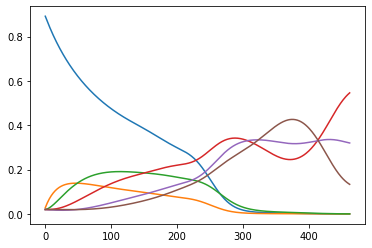

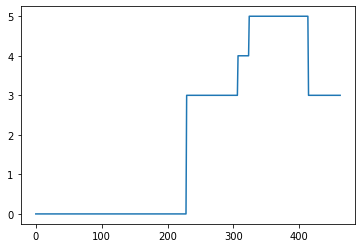

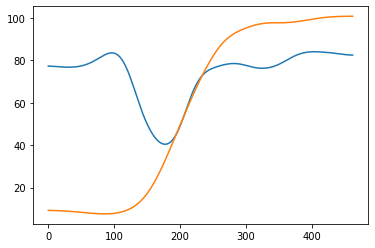

In [26]:
plt.plot(prob_estado)
plt.show()
plt.plot(estado_previsto)
plt.show()
plt.plot(S_rise)
plt.plot(L_rise)
plt.show()

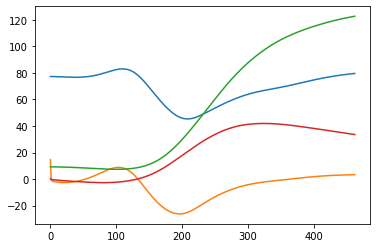

In [27]:
plt.plot(results)